In [1]:
# %matplotlib inline
# %load_ext tensorboard

In [2]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = str(0)

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras  # tf.keras
import time

2023-06-11 05:53:33.557447: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 05:53:33.747822: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-11 05:53:34.595915: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-11 05:53:34.596035: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object fi

In [3]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:21) 
[GCC 9.4.0]
matplotlib 3.5.3
numpy 1.21.6
pandas 1.3.5
sklearn 1.0.2
tensorflow 2.10.1
keras.api._v2.keras 2.10.0


In [4]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

In [5]:
from Mike_NB_tools import *
from Transformer_02 import *

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print(gpus)
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
from datetime import datetime, timedelta
import sys 
sys.path.append('..')
import json

In [8]:
# ============================  Define training parameters ===========================

nnArchitecture = 56 #---------------------------------------

Nx = 600 # ------------- test
Ny = 5
Ns = 5 #--------------------- test
BatchSize = 64

CandleFile = "18-01-01-00-00-23-05-20-20-23-5m"
SmallSigma = 1
LargeSigma = 30
eFreeNoLog = True

nFiles_t = 10
nFiles_v = 10
n_readers = 10
shuffle_batch = 50  # Keep it small to speed up model loading. Sample_anchores already do static shuffling.
nPrefetch = tf.data.AUTOTUNE

dir_data = "/mnt/data/Trading/"
dir_datasets = os.path.join(dir_data, "Datasets", "model_{}".format(nnArchitecture))
dir_candles = os.path.join(dir_data, "Candles")

min_true_candle_percent_x = 40
chosen_markets_x = []
chosen_fields_x = ['ClosePrice'] #, 'BaseVolume']
min_true_candle_percent_y = 40
assert min_true_candle_percent_x == min_true_candle_percent_y
chosen_markets_y = []
chosen_fields_y = ['ClosePrice']

Standardization = True
Kill_Irregulars = True  # ----------------- pls implement it
Time_into_X = True
Time_into_Y = True
Transformer = True
Reuse_files = False
eFreeNoPlot = True

Epochs_Initial = 5000

Num_Layers = 10 # Wow
Num_Heads = 1   # As we have a single GPU, and we want to a exhaustic attention.
Factor_FF = 4
repComplexity = 16  # Wower
Dropout_Rate = 0.1

HuberThreshold = 1.0
CancleLossWeight = 1.0
TrendLossWeight = 30.0

dir_Checkpoint = os.path.join(dir_data, "Checkpoints")
dir_CSVLogs = os.path.join(dir_data, "CSVLogs")
Checkpoint_Monitor = "val_trans_1_mHuber"
EarlyStopping_Min_Monitor = "val_trans_1_mHuber"
EarlyStopping_Patience = 20


In [9]:
folders = [dir_data, dir_datasets, dir_candles, dir_Checkpoint, dir_CSVLogs]
for folder in folders:
    if not os.path.isdir(folder):
        os.mkdir(folder)

In [10]:
#==================== Load candle data into 'table' with shape of (time, markets, 10 fields) ====================
Candles = np.load( os.path.join( dir_candles, "table-" + CandleFile + ".npy") )
Candles = np.swapaxes(Candles, 0, 1)
print("Candles: {}".format(Candles.shape))

Candles: (565633, 336, 10)


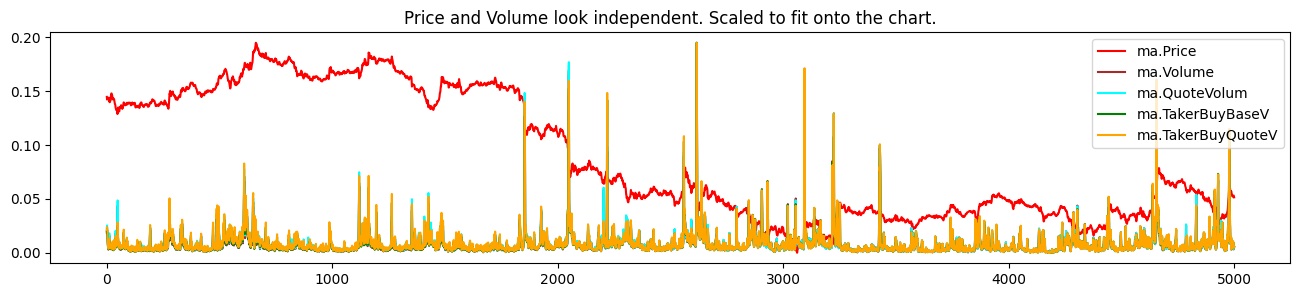

In [11]:
market = 5
Show_Price_Volume_10(Candles[:, market, :], 1, 1, 5000)

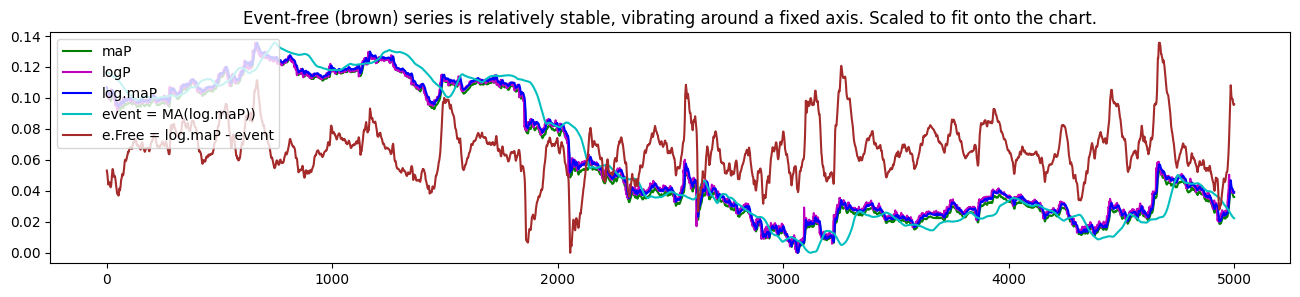

In [12]:
Event_Free_Learning_Scheme_10(Candles[:, market, :], 3, 30, 5000)

In [13]:
#==================== Delete 7 candle fields from 'Candles'. ====================
# Candles.shape becomes (time, markets, ['ClosePrice', 'BaseVolume', 'BuyerBaseVolume'] )

CandleMarks = Candles[:, :, 9] # keep it for later use
Candles = np.delete(Candles, [0, 1, 2, 5, 6, 8, 9], axis = 2) # delete Open, High, Low, qVolume, #Trades, bQVolume, CandleMarks

table_markets = []
with open( os.path.join( dir_candles, "reports-" + CandleFile + ".json"), "r") as f:
    reports = json.loads(f.read())
print(reports[:2])

markets = [ s[0: s.find(':')] for s in reports if 'Success' in s ]
assert Candles.shape[1] == len(markets)
print(Candles.shape, len(markets), markets[:2])

['ALICEUSDT: 565633, 336924 created. Success. 1-th.', 'DOTUSDT: 565633, 277039 created. Success. 2-th.']
(565633, 336, 3) 336 ['ALICEUSDT', 'DOTUSDT']


In [14]:
#==================== Restore timestamps_abs. ====================

start = datetime( 2000+int(CandleFile[0:2]), int(CandleFile[3:5]), int(CandleFile[6:8]), int(CandleFile[9:11]), int(CandleFile[12:14]) )
start_ts = round(datetime.timestamp(start))
interval = CandleFile[ CandleFile.find('-', len(CandleFile) - 4) + 1 : ]
interval_s = round(intervalToMilliseconds(interval) / 1000)
timestamps_abs = np.array( range(start_ts, start_ts + Candles.shape[0] * interval_s, interval_s), dtype=int)
assert timestamps_abs.shape[0] == Candles.shape[0]
print(start_ts, interval_s, timestamps_abs.shape, timestamps_abs[:3])

1514764800 300 (565633,) [1514764800 1514765100 1514765400]


In [15]:
parse_csv_line_to_tensors(b'0., 1., 2., 3., 4., 5., 6., 7., 222., 333., 8., 9., 10., 11., 444., 555.', 2, 4, 2, 2, True, True, 1) # nx, size_x, ny, size_y, time_x, time_y, sixe_time

2023-06-11 05:53:42.960495: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 05:53:43.656080: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38239 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


(<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[  0.,   1.,   2.,   3., 222.],
        [  4.,   5.,   6.,   7., 333.]], dtype=float32)>,
 <tf.Tensor: shape=(6,), dtype=float32, numpy=array([  8.,   9.,  10.,  11., 444., 555.], dtype=float32)>)

In [16]:
parse_csv_line_to_tensors(b'0., 1., 2., 3., 4., 5., 6., 7., 222., 333., 8., 9., 10., 11.', 2, 4, 2, 2, True, False, 1) # nx, size_x, ny, size_y, time_x, time_y, sixe_time

(<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[  0.,   1.,   2.,   3., 222.],
        [  4.,   5.,   6.,   7., 333.]], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 8.,  9., 10., 11.], dtype=float32)>)

In [17]:
parse_csv_line_to_tensors(b'0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11.', 2, 4, 2, 2, False, False, 1) # nx, size_x, ny, size_y, time_x, time_y, sixe_time

(<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[0., 1., 2., 3.],
        [4., 5., 6., 7.]], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 8.,  9., 10., 11.], dtype=float32)>)

In [18]:
parse_csv_line_to_tensors_for_transformer(b'0., 1., 2., 3., 4., 5., 6., 7., 222., 333., 8., 9., 10., 11., 444.', 2, 4, 1, 4, True, True, 1) # nx, size_x, ny, size_y, time_x, time_y, sixe_time

((<tf.Tensor: shape=(4, 6), dtype=float32, numpy=
  array([[  0.,   0.,   0.,   0.,   0.,   0.],
         [  0.,   1.,   2.,   3., 222.,   0.],
         [  4.,   5.,   6.,   7., 333.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.]], dtype=float32)>,
  <tf.Tensor: shape=(2, 6), dtype=float32, numpy=
  array([[  0.,   0.,   0.,   0.,   0.,   0.],
         [  8.,   9.,  10.,  11., 444.,   0.]], dtype=float32)>),
 <tf.Tensor: shape=(2, 6), dtype=float32, numpy=
 array([[  8.,   9.,  10.,  11., 444.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.]], dtype=float32)>)

In [19]:
parse_csv_line_to_tensors_for_transformer(b'0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11.', 2, 4, 1, 4, False, False, 1) # nx, size_x, ny, size_y, time_x, time_y, sixe_time

((<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
  array([[0., 0., 0., 0.],
         [0., 1., 2., 3.],
         [4., 5., 6., 7.],
         [0., 0., 0., 0.]], dtype=float32)>,
  <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
  array([[ 0.,  0.,  0.,  0.],
         [ 8.,  9., 10., 11.]], dtype=float32)>),
 <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[ 8.,  9., 10., 11.],
        [ 0.,  0.,  0.,  0.]], dtype=float32)>)

In [20]:
# defind test data

n_times = 1000; n_markets = 2; n_fields = 2
data = [ [ [ time * n_markets * n_fields + market * n_fields + field for field in range(n_fields) ] for market in range(n_markets) ] for time in range(n_times)]
data = np.array(data, dtype=float)
times_test = np.array( range(data.shape[0]) ) + 100000
print(data.shape, times_test.shape)   # time, market, field
print(data[:2, :, :])

(1000, 2, 2) (1000,)
[[[0. 1.]
  [2. 3.]]

 [[4. 5.]
  [6. 7.]]]


In [21]:
print(data.shape, times_test.shape)   # time, market, field

(1000, 2, 2) (1000,)


In [22]:
nx_test = 2
ny_test = 2
ns_test = 10
batchSize = 2

sample_anchors = range(0, data.shape[0] - nx_test - ny_test, ns_test)
print(data.shape[0], len(sample_anchors), sample_anchors)

x_indices = ( (0, 1), (0, 1) )    # (market, field)
y_indices = ( (0, 1), (0, 1) )    # (market, field)
print(data[0:2][:, x_indices[0]][:, :, x_indices[1]])
print(data[2:4][:, y_indices[0]][:, :, y_indices[1]])

size_x = get_timepoint_size(x_indices)
size_y = get_timepoint_size(y_indices)
size_time = 1
print(size_x, size_y, size_time)


1000 100 range(0, 996, 10)
[[[0. 1.]
  [2. 3.]]

 [[4. 5.]
  [6. 7.]]]
[[[ 8.  9.]
  [10. 11.]]

 [[12. 13.]
  [14. 15.]]]
4 4 1


In [23]:
name_plus = CandleFile+'_o'
name_prefix = os.path.join(dir_datasets, name_plus)

reuse_files = False

if reuse_files:
    import re
    filenames = [ os.path.join(dir_datasets, x) for x in os.listdir(dir_datasets) if re.match(name_plus, x)]
else:
    os.system("rm {}/*{}*".format(dir_datasets, name_plus))
    filenames = divide_to_multiple_csv_files(data, True, True, times_test, sample_anchors, name_prefix, nx_test, x_indices, ny_test, y_indices, header=None, n_parts=10)

print(filenames)

['/mnt/data/Trading/Datasets/model_56/18-01-01-00-00-23-05-20-20-23-5m_o_00.csv', '/mnt/data/Trading/Datasets/model_56/18-01-01-00-00-23-05-20-20-23-5m_o_01.csv', '/mnt/data/Trading/Datasets/model_56/18-01-01-00-00-23-05-20-20-23-5m_o_02.csv', '/mnt/data/Trading/Datasets/model_56/18-01-01-00-00-23-05-20-20-23-5m_o_03.csv', '/mnt/data/Trading/Datasets/model_56/18-01-01-00-00-23-05-20-20-23-5m_o_04.csv', '/mnt/data/Trading/Datasets/model_56/18-01-01-00-00-23-05-20-20-23-5m_o_05.csv', '/mnt/data/Trading/Datasets/model_56/18-01-01-00-00-23-05-20-20-23-5m_o_06.csv', '/mnt/data/Trading/Datasets/model_56/18-01-01-00-00-23-05-20-20-23-5m_o_07.csv', '/mnt/data/Trading/Datasets/model_56/18-01-01-00-00-23-05-20-20-23-5m_o_08.csv', '/mnt/data/Trading/Datasets/model_56/18-01-01-00-00-23-05-20-20-23-5m_o_09.csv']


In [24]:
filename_dataset = tf.data.Dataset.list_files(filenames, shuffle=None) # no way to prevent shuffle.
print(filename_dataset.cardinality().numpy())
for element in filename_dataset:
    print(element.numpy())

10
b'/mnt/data/Trading/Datasets/model_56/18-01-01-00-00-23-05-20-20-23-5m_o_05.csv'
b'/mnt/data/Trading/Datasets/model_56/18-01-01-00-00-23-05-20-20-23-5m_o_07.csv'
b'/mnt/data/Trading/Datasets/model_56/18-01-01-00-00-23-05-20-20-23-5m_o_08.csv'
b'/mnt/data/Trading/Datasets/model_56/18-01-01-00-00-23-05-20-20-23-5m_o_09.csv'
b'/mnt/data/Trading/Datasets/model_56/18-01-01-00-00-23-05-20-20-23-5m_o_01.csv'
b'/mnt/data/Trading/Datasets/model_56/18-01-01-00-00-23-05-20-20-23-5m_o_02.csv'
b'/mnt/data/Trading/Datasets/model_56/18-01-01-00-00-23-05-20-20-23-5m_o_06.csv'
b'/mnt/data/Trading/Datasets/model_56/18-01-01-00-00-23-05-20-20-23-5m_o_03.csv'
b'/mnt/data/Trading/Datasets/model_56/18-01-01-00-00-23-05-20-20-23-5m_o_00.csv'
b'/mnt/data/Trading/Datasets/model_56/18-01-01-00-00-23-05-20-20-23-5m_o_04.csv'


In [25]:
ds = tf.data.TextLineDataset(filenames[0])
for line in ds.take(20):
    print(line.numpy())

b'0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,100000.0,100001.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,100002.0,100003.0'
b'40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,100010.0,100011.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,100012.0,100013.0'
b'80.0,81.0,82.0,83.0,84.0,85.0,86.0,87.0,100020.0,100021.0,88.0,89.0,90.0,91.0,92.0,93.0,94.0,95.0,100022.0,100023.0'
b'120.0,121.0,122.0,123.0,124.0,125.0,126.0,127.0,100030.0,100031.0,128.0,129.0,130.0,131.0,132.0,133.0,134.0,135.0,100032.0,100033.0'
b'160.0,161.0,162.0,163.0,164.0,165.0,166.0,167.0,100040.0,100041.0,168.0,169.0,170.0,171.0,172.0,173.0,174.0,175.0,100042.0,100043.0'
b'200.0,201.0,202.0,203.0,204.0,205.0,206.0,207.0,100050.0,100051.0,208.0,209.0,210.0,211.0,212.0,213.0,214.0,215.0,100052.0,100053.0'
b'240.0,241.0,242.0,243.0,244.0,245.0,246.0,247.0,100060.0,100061.0,248.0,249.0,250.0,251.0,252.0,253.0,254.0,255.0,100062.0,100063.0'
b'280.0,281.0,282.0,283.0,284.0,285.0,286.0,287.0,100070.0,100071.0,288.0,289.0,290.0,291.0,292.0,293.0,294.0,295

In [26]:
n_readers = 5
dataset = filename_dataset.interleave(
    lambda filename: tf.data.TextLineDataset(filename),
    cycle_length=n_readers, num_parallel_calls=tf.data.AUTOTUNE) # no way to prevent shuffle?

for line in dataset.take(15):
    print(line.numpy())

b'3600.0,3601.0,3602.0,3603.0,3604.0,3605.0,3606.0,3607.0,100900.0,100901.0,3608.0,3609.0,3610.0,3611.0,3612.0,3613.0,3614.0,3615.0,100902.0,100903.0'
b'1200.0,1201.0,1202.0,1203.0,1204.0,1205.0,1206.0,1207.0,100300.0,100301.0,1208.0,1209.0,1210.0,1211.0,1212.0,1213.0,1214.0,1215.0,100302.0,100303.0'
b'2400.0,2401.0,2402.0,2403.0,2404.0,2405.0,2406.0,2407.0,100600.0,100601.0,2408.0,2409.0,2410.0,2411.0,2412.0,2413.0,2414.0,2415.0,100602.0,100603.0'
b'0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,100000.0,100001.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,100002.0,100003.0'
b'2800.0,2801.0,2802.0,2803.0,2804.0,2805.0,2806.0,2807.0,100700.0,100701.0,2808.0,2809.0,2810.0,2811.0,2812.0,2813.0,2814.0,2815.0,100702.0,100703.0'
b'3640.0,3641.0,3642.0,3643.0,3644.0,3645.0,3646.0,3647.0,100910.0,100911.0,3648.0,3649.0,3650.0,3651.0,3652.0,3653.0,3654.0,3655.0,100912.0,100913.0'
b'1240.0,1241.0,1242.0,1243.0,1244.0,1245.0,1246.0,1247.0,100310.0,100311.0,1248.0,1249.0,1250.0,1251.0,1252.0,1253.0,1254.0,1255.0,1003

In [27]:
dataset = csv_reader_to_dataset(filenames, nx_test, size_x, ny_test, size_y, True, True, size_time,
                             n_parse_threads=5, batch_size=batchSize, shuffle_buffer_size=1000, n_readers=5)

In [28]:
for element in dataset:
    print(element)
    break

# should print: (None, nx_test, size_x + size_time), (None, ny_test * size_y)

(<tf.Tensor: shape=(2, 2, 5), dtype=float32, numpy=
array([[[  3480.,   3481.,   3482.,   3483., 100870.],
        [  3484.,   3485.,   3486.,   3487., 100871.]],

       [[   800.,    801.,    802.,    803., 100200.],
        [   804.,    805.,    806.,    807., 100201.]]], dtype=float32)>, <tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[  3488.,   3489.,   3490.,   3491.,   3492.,   3493.,   3494.,
          3495., 100872., 100873.],
       [   808.,    809.,    810.,    811.,    812.,    813.,    814.,
           815., 100202., 100203.]], dtype=float32)>)


In [29]:
# Check elements: NaN, -inf, +inf

assert (~np.isfinite(Candles)).any() == False

In [30]:
nLatest = 500
P, maP, logP, log_maP, event, eventFree = Get_eFree(Candles[:, 0, 0], 1, 30, nLatest)
assert maP.shape[0] == nLatest; assert logP.shape[0] == nLatest; assert log_maP.shape[0] == nLatest; assert event.shape[0] == nLatest; assert eventFree.shape[0] == nLatest


In [31]:
clusters = [
    ['APT', 'SUI', 'DYDX', 'ANKR', 'AUDIO', 'SKL'],
    ['EOS', 'AAVE', 'FLOW', 'CRV', 'COMP', 'SLP', 'MBOX', 'BNT', 'SPELL', 'AERGO', 'BAKE'],
    ['DOT', 'BTC', 'ETH', 'WBTC', 'LINK', 'ETC', 'XLM', 'TWT', 'SFP', 'STPT', 'STEEM', 'POWR'],
]

for c in range(len(clusters)):
    cluster = clusters[c]
    cluster = [ markets.index(m + 'USDT') for m in cluster ]
    check = [ (markets[m], 100 - round(np.argmax(Candles[:, m, 0]>0) / Candles.shape[0] * 100)) for m in cluster ]
    print(check)

[('APTUSDT', 11), ('SUIUSDT', 1), ('DYDXUSDT', 31), ('ANKRUSDT', 71), ('AUDIOUSDT', 48), ('SKLUSDT', 46)]
[('EOSUSDT', 93), ('AAVEUSDT', 48), ('FLOWUSDT', 33), ('CRVUSDT', 51), ('COMPUSDT', 54), ('SLPUSDT', 38), ('MBOXUSDT', 32), ('BNTUSDT', 61), ('SPELLUSDT', 26), ('AERGOUSDT', 1), ('BAKEUSDT', 38)]
[('DOTUSDT', 51), ('BTCUSDT', 100), ('ETHUSDT', 100), ('WBTCUSDT', 1), ('LINKUSDT', 81), ('ETCUSDT', 92), ('XLMUSDT', 92), ('TWTUSDT', 43), ('SFPUSDT', 42), ('STPTUSDT', 59), ('STEEMUSDT', 20), ('POWRUSDT', 28)]


In [32]:
#==================== Define Data ====================

Data = Candles[:, :, :]   # (time:, all markets, 20 fields)

In [33]:
#===================== Find marketrank ==================

check = np.array([ np.argmax(Data[:, m, 0]>0) / Data.shape[0] * 100 for m in range(len(markets)) ])
permute = np.argsort(check)
marketrank = [ (markets[m], 100 - round(np.argmax(Data[:, m, 0]>0) / Data.shape[0] * 100)) for m in permute ]
# marketrank = [ markets[m] for m in permute ]

batch = 10
for i in range(0, len(markets), batch):
    print(marketrank[i: i+batch])

[('NEOUSDT', 100), ('LTCUSDT', 100), ('BTCUSDT', 100), ('ETHUSDT', 100), ('BNBUSDT', 100), ('QTUMUSDT', 96), ('ADAUSDT', 95), ('XRPUSDT', 94), ('EOSUSDT', 93), ('XLMUSDT', 92)]
[('IOTAUSDT', 92), ('ONTUSDT', 92), ('TRXUSDT', 92), ('ETCUSDT', 92), ('ICXUSDT', 92), ('NULSUSDT', 90), ('VETUSDT', 90), ('LINKUSDT', 81), ('WAVESUSDT', 81), ('ONGUSDT', 79)]
[('HOTUSDT', 79), ('ZILUSDT', 79), ('ZRXUSDT', 78), ('FETUSDT', 78), ('BATUSDT', 78), ('XMRUSDT', 78), ('ZECUSDT', 77), ('IOSTUSDT', 77), ('CELRUSDT', 77), ('DASHUSDT', 77)]
[('OMGUSDT', 77), ('THETAUSDT', 76), ('ENJUSDT', 76), ('MATICUSDT', 76), ('ATOMUSDT', 75), ('TFUELUSDT', 74), ('ONEUSDT', 74), ('FTMUSDT', 73), ('ALGOUSDT', 73), ('DOGEUSDT', 72)]
[('DUSKUSDT', 71), ('ANKRUSDT', 71), ('WINUSDT', 71), ('COSUSDT', 70), ('COCOSUSDT', 70), ('MTLUSDT', 69), ('TOMOUSDT', 69), ('PERLUSDT', 69), ('KEYUSDT', 69), ('WANUSDT', 69)]
[('FUNUSDT', 69), ('DENTUSDT', 69), ('DOCKUSDT', 69), ('CHZUSDT', 69), ('BANDUSDT', 68), ('BUSDUSDT', 68), ('XTZUSDT

In [34]:
#==================== Select markets and fields ====================

enFields = ['ClosePrice', 'BaseVolume', 'BuyerBaseVolume']

# dot, 1inch, btc, eth, matic, bnb, ada, sol, ltc, avax, wbtc, link, arb, ape, aave, crv, sui, op, gmx, agix, bal, comp, gmt, joe, stg

chosen_markets_x = [ elem[0] for elem in marketrank if elem[1] >= min_true_candle_percent_x ]
chosen_markets_x = tuple([ markets.index(elem) for elem in chosen_markets_x ])
chosen_markets_x = tuple(list(set(chosen_markets_x)))

chosen_fields_x = tuple( [ enFields.index(elem) for elem in chosen_fields_x ] )
chosen_fields_x = tuple(list(set(chosen_fields_x)))
x_indices = ( chosen_markets_x, chosen_fields_x )
print(x_indices)

chosen_markets_y = [ elem[0] for elem in marketrank if elem[1] >= min_true_candle_percent_y ]
chosen_markets_y = tuple([ markets.index(elem) for elem in chosen_markets_y ])
chosen_markets_y = tuple(list(set(chosen_markets_y)))

chosen_fields_y = tuple( [ enFields.index(elem) for elem in chosen_fields_y ] )
chosen_fields_y = tuple(list(set(chosen_fields_y)))
y_indices = ( chosen_markets_y, chosen_fields_y )
print(y_indices)

size_x = get_timepoint_size(x_indices)
size_y = get_timepoint_size(y_indices)
print(size_x, size_y)

chosen_markets = tuple(list(set(chosen_markets_x + chosen_markets_y)))
chosen_fields = tuple(list(set(chosen_fields_x + chosen_fields_y)))
print(chosen_markets, chosen_fields)

print(len(chosen_markets), len(chosen_fields))

((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 24, 25, 28, 29, 31, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 52, 53, 54, 56, 58, 62, 63, 64, 69, 70, 71, 72, 75, 76, 78, 81, 83, 85, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 109, 110, 111, 112, 115, 116, 117, 118, 120, 121, 123, 124, 125, 128, 129, 132, 136, 137, 138, 140, 146, 147, 148, 149, 150, 152, 154, 159, 160, 161, 162, 163, 166, 176, 183, 184, 186, 187, 190, 194, 195, 197, 198, 199, 200, 202, 203, 204, 205, 206, 208, 209, 211, 212, 214, 218, 221, 222, 223, 226, 227, 228, 230, 231, 235, 236, 238, 245, 246, 247, 249, 250, 253, 254, 256, 259, 264, 265, 274, 275, 276, 279, 283, 285, 286, 287, 289, 292, 294, 295, 298, 299, 300, 301, 302, 304, 305, 307, 309, 312, 313, 320, 321, 324, 325, 327, 330, 332, 333, 334, 335), (0,))
((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 24, 25, 28, 29, 31, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 52,

In [35]:
chosen_market_names = [markets[market][:-4] for market in chosen_markets]
batch = 10
for i in range(0, len(chosen_market_names), batch):
    print(chosen_market_names[i: i+batch])
print(len(chosen_market_names))

['ALICE', 'DOT', '1INCH', 'BTC', 'ETH', 'MATIC', 'BNB', 'XRP', 'ADA', 'DOGE']
['SOL', 'LTC', 'TRX', 'BUSD', 'AVAX', 'LINK', 'UNI', 'ATOM', 'XMR', 'ETC']
['XLM', 'BCH', 'FIL', 'HBAR', 'NEAR', 'VET', 'ALGO', 'GRT', 'FTM', 'SAND']
['EOS', 'EGLD', 'AAVE', 'STX', 'MANA', 'THETA', 'CFX', 'XTZ', 'AXS', 'CHZ']
['CRV', 'NEO', 'SNX', 'MKR', 'INJ', 'KAVA', 'PAXG', 'ZEC', 'DASH', 'IOTA']
['TWT', 'LRC', 'ZIL', 'RUNE', 'CAKE', 'ENJ', 'BAT', 'ROSE', 'XEM', 'HOT']
['RVN', 'QTUM', 'TFUEL', 'COMP', 'BAL', 'CELO', 'ANKR', 'DCR', 'AUDIO', 'LUNA']
['SXP', 'ICX', 'ONE', 'YFI', 'KSM', 'IOTX', 'FET', 'JST', 'SUSHI', 'OCEAN']
['ONT', 'ZRX', 'BAND', 'WAVES', 'SC', 'IOST', 'HIVE', 'CELR', 'UMA', 'SFP']
['RSR', 'SKL', 'ANT', 'CTSI', 'CKB', 'RIF', 'DGB', 'STORJ', 'COCOS', 'ZEN']
['RLC', 'OMG', 'LSK', 'KNC', 'TOMO', 'CHR', 'NMR', 'STPT', 'ONG', 'DENT']
['COTI', 'VTHO', 'ALPHA', 'ARDR', 'REN', 'WNXM', 'NKN', 'XVS', 'STRAX', 'WIN']
['POND', 'CTK', 'MTL', 'ARPA', 'OXT', 'BNT', 'DUSK', 'DODO', 'UTK', 'FUN']
['SUPER', '

In [36]:
#==================== Generate event-free data into Data ====================
# Data loses heading items.
# Do it before: Permute Data in time

alpha = 3; beta = 3 # beta is used in 'get_eFree_with_plot'. Ugly coupling.
event_free_data_loss = 3 * ( alpha * SmallSigma + LargeSigma)
eFree = np.zeros( (Data.shape[0] - event_free_data_loss, len(chosen_markets), len(chosen_fields)), dtype = np.float32 )

for market in chosen_markets:
    for field in chosen_fields:
        sSigma = SmallSigma
        if enFields[field] == 'BaseVolume': sSigma = SmallSigma * alpha
        P, maP, logP, log_maP, event, eventFree = \
        get_eFree_with_plot(markets[market], enFields[field], Data[:, market, field], sSigma, 
                            LargeSigma, Data.shape[0] - event_free_data_loss, noPlot=eFreeNoPlot, noLog=eFreeNoLog)
        Data[event_free_data_loss:, market, field] = eventFree

Data = Data[event_free_data_loss: ]

print(Data.shape)

(565534, 336, 3)


In [37]:
#==================== Define time features, to augment Data with ====================

sigma = np.power(2.0, -0.2)
hourly = np.sin( 2 * np.pi / (60*60) * timestamps_abs ) / sigma
daily = np.sin( 2 * np.pi / (60*60*24) * timestamps_abs ) / sigma
weekly = np.sin( 2 * np.pi / (60*60*24*7) * timestamps_abs ) / sigma
yearly = np.sin( 2 * np.pi / (60*60*24*365) * timestamps_abs ) / sigma
tenyearly = np.sin( 2 * np.pi / (60*60*24*365*10) * timestamps_abs ) / sigma    # Let the model absorb non-cyclic time features.

Time = np.stack([hourly, daily, weekly, yearly], axis=1)
size_time = Time.shape[1]

Time = Time[event_free_data_loss: ]
assert Data.shape[0] == Time.shape[0]
print(Candles.shape, Time.shape)

(565633, 336, 3) (565534, 4)


In [38]:
#==================== Standardize Data on chosen markets and fields ====================

Standard = []

if Standardization:
    for market in chosen_markets:
        for field in chosen_fields:
            nzPs = np.where( Data[:, market, field] != 0.0 ) [0]
            mu = np.average(Data[nzPs, market, field])
            sigma = np.std(Data[nzPs, market, field])
            standard = (Data[nzPs, market, field] - mu) / (sigma + 1e-15)
            Standard.append( (market, field, mu, sigma) )
            Data[nzPs, market, field] = standard

    Standard = np.array(Standard)

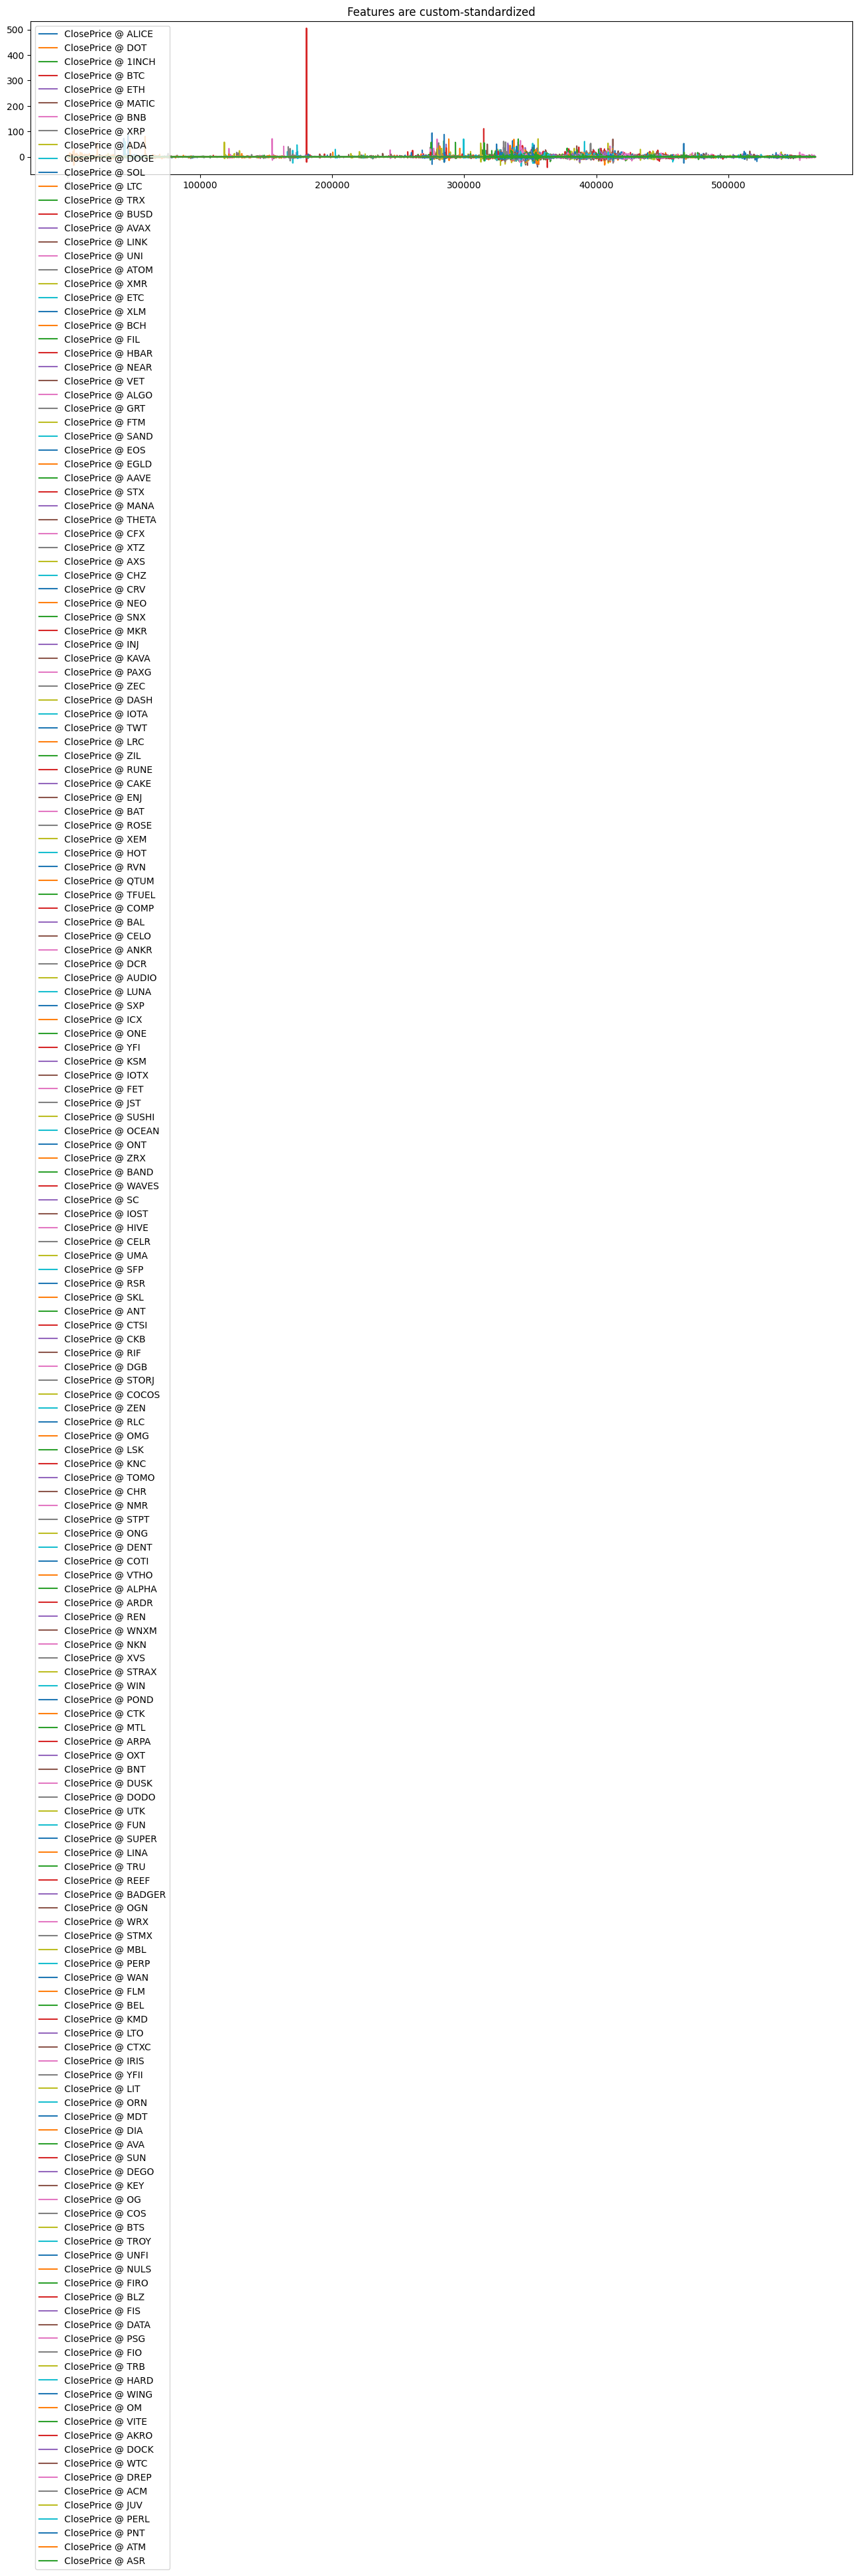

In [39]:
fig = plt.figure(figsize=(16,3))
ax = fig.add_subplot(111)
ax.set_title("Features are custom-standardized" if Standardization else "Features are not standardized")
for market in chosen_markets:
    for field in chosen_fields:
        ax.plot(Data[:, market, field], label = "{} @ {}".format(enFields[field], markets[market][:-4])) # -4: 'USDT'
ax.legend(loc = 'upper left')
plt.show()

In [40]:
#==================== Define input sequence and output sequence ====================

sample_anchors = np.array(range(0, Data.shape[0] - Nx - Ny + 1, Ns))
print(Data.shape[0], len(sample_anchors), sample_anchors, sample_anchors[-1])
print(Data.shape[0], sample_anchors[ -1 ], sample_anchors[ -1 ] + Nx + Ny, sample_anchors[ -1 ] + Ns, sample_anchors[ -1 ] + Ns + Nx + Ny)

for _ in range(100):
    permute = np.random.permutation(sample_anchors.shape[0])
    sample_anchors = sample_anchors[permute]

from sklearn.model_selection import train_test_split
sample_anchores_t, sample_anchores_v = train_test_split(sample_anchors, test_size=0.30, random_state=42)
print(sample_anchores_t.shape, sample_anchores_v.shape)

sample_anchores_t = tuple(sample_anchores_t)
sample_anchores_v = tuple(sample_anchores_v)

565534 112986 [     0      5     10 ... 564915 564920 564925] 564925
565534 564925 565530 564930 565535
(79090,) (33896,)


In [41]:
#==================== Create train/valid datasets ====================

name_plus_t = CandleFile+'_t'
name_plus_v = CandleFile+'_v'
name_prefix_t = os.path.join(dir_datasets, name_plus_t)
name_prefix_v = os.path.join(dir_datasets, name_plus_v)

reuse_files = Reuse_files #------------------------------------------------------------------------------------------------------- 

if reuse_files:
    import re
    filenames_train = [ os.path.join(dir_datasets, x) for x in os.listdir(dir_datasets) if re.match(name_plus_t, x)]
    filenames_valid = [ os.path.join(dir_datasets, x) for x in os.listdir(dir_datasets) if re.match(name_plus_v, x)]
else:
    os.system("rm {}/*{}*".format(dir_datasets, name_plus_t))
    os.system("rm {}/*{}*".format(dir_datasets, name_plus_v))
    filenames_train = divide_to_multiple_csv_files(Data, Time_into_X, Time_into_Y, Time, sample_anchores_t, name_prefix_t, Nx, x_indices, Ny, y_indices, header=None, n_parts=nFiles_t)
    filenames_valid = divide_to_multiple_csv_files(Data, Time_into_X, Time_into_Y, Time, sample_anchores_v, name_prefix_v, Nx, x_indices, Ny, y_indices, header=None, n_parts=nFiles_v)

# sample_anchores are already shuffled. But we need to shuffle datasets again, because it will reshuffle at every epoch.
Dataset_train = csv_reader_to_dataset(filenames_train, Nx, size_x, Ny, size_y, Time_into_X, Time_into_Y, size_time,
                             n_parse_threads=5, batch_size=BatchSize, shuffle_buffer_size=BatchSize*shuffle_batch, n_readers=n_readers, transformer=Transformer)
Dataset_train = Dataset_train.prefetch(nPrefetch)

Dataset_valid = csv_reader_to_dataset(filenames_valid, Nx, size_x, Ny, size_y, Time_into_X, Time_into_Y, size_time,
                             n_parse_threads=5, batch_size=BatchSize, shuffle_buffer_size=BatchSize*shuffle_batch, n_readers=n_readers, transformer=Transformer)
Dataset_valid = Dataset_valid.prefetch(nPrefetch)

rm: cannot remove '/mnt/data/Trading/Datasets/model_56/*18-01-01-00-00-23-05-20-20-23-5m_v*': No such file or directory


In [42]:
dx = size_x + (size_time if Time_into_X else 0)
if Transformer: dx = dx + dx % 2
dy = size_y + (size_time if Time_into_Y else 0)
if Transformer: dy = dy + dy % 2
if Transformer: assert dx == dy

In [43]:
# Build model

cryptoformer = ConTransformer(
  num_layers=Num_Layers, d_model=dx, num_heads=Num_Heads, dff=Factor_FF*dx, 
  repComplexity=repComplexity, dropout_rate=Dropout_Rate
)

# cryptoformer.summary()

In [44]:
# cryptoformer.compile(
#     loss=MaskedMSE,
#     optimizer=keras.optimizers.Adam(
#         learning_rate=0.0001,  # def lr = 0.001
#         beta_1=0.9,
#         beta_2=0.999, 
#         epsilon=1e-07
#     ),
#     metrics=keras.metrics.MSE,       
# )

# cryptoformer.fit(Dataset_train, validation_data=Dataset_valid, epochs=1)

In [45]:
candle_input_x = keras.Input( shape=( (None, dx) ), name='candle_input_x' )
candle_input_y = keras.Input( shape=( (None, dx) ), name='candle_input_y' )
candle_input_shifted_y = keras.Input( shape=( (None, dx) ), name='candle_input_shifted_y' )

cryptoformer_input = (candle_input_x, candle_input_y)
cryptoformer_output = cryptoformer(cryptoformer_input)

model = keras.Model(
    inputs = [cryptoformer_input],
    outputs = { "value": cryptoformer_output, "trend": cryptoformer_output }
)

model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=0.001,  # def lr = 0.001
        beta_1=0.9,
        beta_2=0.999, 
        epsilon=1e-07
    ),
    loss={
        "value": MaskedHuber(threshold=HuberThreshold),
        "trend": MaskedTrendError() 
    },
    loss_weights={ 
        "value": CancleLossWeight, 
        "trend": TrendLossWeight 
    },
    metrics={ 
        "value": [MaskedHuber_Metric()], 
        "trend": [MaskedTrendError_Metric(), MaskedTrendAccuracy_Metric()]
    }
)

model.summary()
# cryptoformer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 candle_input_x (InputLayer)    [(None, None, 188)]  0           []                               
                                                                                                  
 candle_input_y (InputLayer)    [(None, None, 188)]  0           []                               
                                                                                                  
 trans (ConTransformer)         (None, None, 188)    19082188    ['candle_input_x[0][0]',         
                                                                  'candle_input_y[0][0]']         
                                                                                                  
Total params: 19,082,188
Trainable params: 19,082,188
Non-trainable params: 0
________________

In [46]:
# (x, y), y_target = next(iter(Dataset_train))
# print(x.shape, y.shape, y_target.shape)
# print(x)
# print(y)

In [47]:
# pos = ConPositionalEmbedding(complexity=2, d_model=dx, dff=4*dx, dropout_rate=dropout_rate)
# p = pos(x)
# print(p.shape)
# p = pos(y)
# print(p.shape)

# encoder = ConEncoder(num_layers=2, d_model=dx, num_heads=1, dff=4*dx, repComplexity=2, dropout_rate=0.1)
# decoder = ConDecoder(num_layers=2, d_model=dy, num_heads=2, dff=4*dy, repComplexity=2, dropout_rate=0.1)
# enc = encoder(x)
# print(enc.shape)
# dec = decoder(x, enc)
# print(dec.shape)

# c = cryptoformer((x,y))
# print(c.shape)
# print(c)

# m = model((x,y))
# print(m)

In [48]:
# Build a checkpoint callback, and load if a checkpoint exists.

checkpoint_filepath = os.path.join(dir_Checkpoint, "model_" + str(nnArchitecture))
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor=Checkpoint_Monitor,
    mode='min',
    save_best_only=True,
    save_freq='epoch',
    # initial_value_threshold=0.5,
)

try:
    model.load_weights(checkpoint_filepath)
except:
    pass

In [49]:
# Build a csv logger.

csvLogger_filepath = os.path.join(dir_CSVLogs, "model_" + str(nnArchitecture) + ".csv" )
history_logger=tf.keras.callbacks.CSVLogger(csvLogger_filepath, separator=",", append=True)

In [50]:
# Build an early-stopping callback.

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor=EarlyStopping_Min_Monitor,
    patience=EarlyStopping_Patience,
    mode='min',
    restore_best_weights=True
)

In [ ]:
model.fit(
    Dataset_train, # x and y_true
    validation_data=Dataset_valid, 
    epochs=20,
    callbacks=[model_checkpoint_callback, history_logger, early_stopping_callback]
)

Epoch 1/20


2023-06-11 08:48:35.716571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1381 of 3200
2023-06-11 08:48:45.716794: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 2847 of 3200
2023-06-11 08:48:48.146188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2023-06-11 08:48:51.385598: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-06-11 08:48:52.275788: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


   1236/Unknown - 2577s 2s/step - loss: nan - trans_loss: nan - trans_1_loss: nan - trans_mTE: nan - trans_mTA: 8.6291e-04 - trans_1_mHuber: nan

In [ ]:
columns = ('loss', 'val_loss', 'trans_mTA', 'val_trans_mTA', 'trans_1_loss', 'val_trans_1_loss')
plot_csv_log_history(csvLogger_filepath, columns)

In [ ]:
STEPS_PER_EPOCH = len(sample_anchores_t) // BatchSize

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001, # default: 0.001 
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=Epochs_Initial,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [ ]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]